<h1 style="text-align: center;"> Qiskit Fall Fest 2025 Paris-Saclay - hackathon </h1>

## Quandela challenge 2 - QML for swaptions prediction

This notebook tackles the 2nd challenge presented by Quandela at the Qiskit Fall Fest 2025 Paris-Saclay hackathon.

Here we predict future swaptions prices by applying Quantum Machine Learning to a given dataset.

We have chosen to rely on the Quantum Reservoir Computing (QRC) model, implementing the process described in the provided reference available at https://arxiv.org/abs/2505.13933 with a single quantum reservoir (QR1).

See README.txt file for more detailed info

In [1]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Batch, SamplerV2 as Sampler
from qiskit_aer import AerSimulator

from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter, ParameterVector
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA

# Step 1.1: data management - PCA compression

In [2]:
# Data readout and management
full_dataset = pd.read_excel("Datasets/Dataset_Simulated_Price_swaption.xlsx", engine="openpyxl")
prices_dataset = full_dataset.iloc[:,:-1].copy()
dates_dataset = full_dataset.iloc[:,-1].copy()
print("Full dataset dimension:", full_dataset.shape)
print("Prices dataset dimension", prices_dataset.shape)

# Principal Component Analysis (PCA) reduction: extract 3 PCs
n_components = 3
pca = PCA(n_components)
pca_prices_dataset = pca.fit_transform(prices_dataset.values)   # Apply PCA transformation to prices_dataset --> return ndarray
print(f"PCA prices dataset dimension: {pca_prices_dataset.shape}\n")

# Normalize each PC to [0,2π] with min-max normalization
pca_min_values = pca_prices_dataset.min(axis = 0)
pca_max_values = pca_prices_dataset.max(axis = 0)
pca_prices_dataset_norm = 2 * np.pi *(pca_prices_dataset - pca_min_values) / (pca_max_values - pca_min_values)

# Principal Component time series
pc1 = pca_prices_dataset_norm[:, 0]
pc2 = pca_prices_dataset_norm[:, 1]
pc3 = pca_prices_dataset_norm[:, 2]

# Variance captured by each PCs:
pca_variances = pca.explained_variance_ratio_
print(f"Variance captured by PC1, PC2, PC3: {pca_variances}\n")

# Converts pca_prices_dataset_norm into a DataFrame object
pca_prices_dataset_norm = pd.DataFrame({
    "PC1": pc1,
    "PC2": pc2,
    "PC3": pc3,
    "Date": dates_dataset.values
})

Full dataset dimension: (500, 225)
Prices dataset dimension (500, 224)
PCA prices dataset dimension: (500, 3)

Variance captured by PC1, PC2, PC3: [0.76204614 0.20735868 0.03015435]



# Step 1.2: data management - build the input data for the QRC circuit

In [3]:
###########################
# USER-DEFINED PARAMETERS
###########################

lags = 3   # We use 3 lags (t-3, t-2, t-1) in this project. This will also determine the number of layers in the QRC circuit

In [4]:
num_days = len(pca_prices_dataset_norm)

# Number of days after removing first lags days
num_samples = num_days - lags

# Prepare input feature matrix X and target vector y. The targets are PC1, PC2, PC3 at time t
X = np.zeros((num_samples, 3 * lags))  # 3 PCs values for each lag t-1, t-2, t-3, for each date t --> 9 parameters per row
y = np.zeros((num_samples, 3))         # 3 PCs at time t as targets - these are the original dataset values

for t in range(lags, num_days):
    # Build input features matrix X: 9 parameters for each date t starting from day "lags"
    X[t - lags, :] = np.concatenate([
        pca_prices_dataset_norm.iloc[t-3][["PC1", "PC2", "PC3"]].values,
        pca_prices_dataset_norm.iloc[t-2][["PC1", "PC2", "PC3"]].values,
        pca_prices_dataset_norm.iloc[t-1][["PC1", "PC2", "PC3"]].values
    ])

    # Build target vector: PC1, PC2, PC3 at time t
    y[t - lags, :] = pca_prices_dataset_norm.iloc[t][["PC1", "PC2", "PC3"]].values
print(f"Feature matrix dimension: {X.shape}")
print(f"Target vector dimension: {y.shape}\n")

# Split dataset into Train and Test
train_size = int(0.7 * num_samples)   # 70% train, 30% test subdivision
test_size = num_samples - train_size
print(f"Dataset subdivision: 70% train, 30% test --> training size: {train_size} days, test_size: {test_size} days\n")

y_train = y[:train_size]
y_test = y[train_size:]

Feature matrix dimension: (497, 9)
Target vector dimension: (497, 3)

Dataset subdivision: 70% train, 30% test --> training size: 347 days, test_size: 150 days



# Step 2: construct the QRC quantum circuit

First of all, we want to encode each PC for a fixed date into a related input qubit: we do so using angle encoding (parametrized RY roation).

In second place, we want to implement the simple linearly-connected Ising Hamiltonian

\begin{equation}
    \large H = \sum_{i<j} J_{ij} X_i X_j + \nu \sum_i Z_i,
\end{equation}

where the magnetic field strength $\nu$ and the exchange coupling strenght $J_{ij}$ are chosen by the user. We assume J to couple each input qubit with each hidden qubit withouth intra-set coupling, that is, $J_{ij}=0$ if $i,j$ are both input qubits or both hidden qubits, and $J_{ij}=1$ otherwise.

The corresponding evolution operator is $U(t)=e^{iHt}$, where the evolution time t is chosen by the user and $\hbar$ has been set to 1. In order to implement such dynamics, we perform a first-step Trotter approximation:

\begin{equation}
    \large
    U(t)
    \approx
    e^{-i t \sum_{i<j} J_{ij} X_i X_j}\,
    e^{-i t\,\nu \sum_i Z_i}
    =
    \prod_{i<j} e^{-i\,J_{ij} X_i X_j\, t}
    \,
    \prod_i e^{-i\,\nu Z_i\, t}
    =
        \prod_{i<j} RXX(2J_{ij}\,t)
    \,
    \prod_i RZ(2\nu\,t),
\end{equation}
that is, we need to implement $RXX$ and $RZ$ rotations.

In [5]:
###########################
# USER-DEFINED PARAMETERS
###########################

n_hidden = 7     # Number of hidden qubits chosen for the reservoir

dt = 1.   # Hamiltonian parameter: evolution time
nu = 1.   # Hamiltonian parameter: strength of the magnetic field
J = 1.    # Hamiltonian parameter: exchange coupling, here = 1 between input qubits and hidden qubits and = 0 within each set
hamiltonian_params = [dt, nu, J]

In [6]:
# We need three input qubits (one to encode each PC feature) and three layers (t-3,t-2,t-1)
n_input = n_components       # The model requires one qubit per feature = one qubit per PC
n_qubits = n_input + n_hidden
n_layers = lags  # 3 layers in this project
print(f"Circuit parameters: {n_input * n_layers} ({n_input} PC-parameters per {n_layers} layers)")

Circuit parameters: 9 (3 PC-parameters per 3 layers)


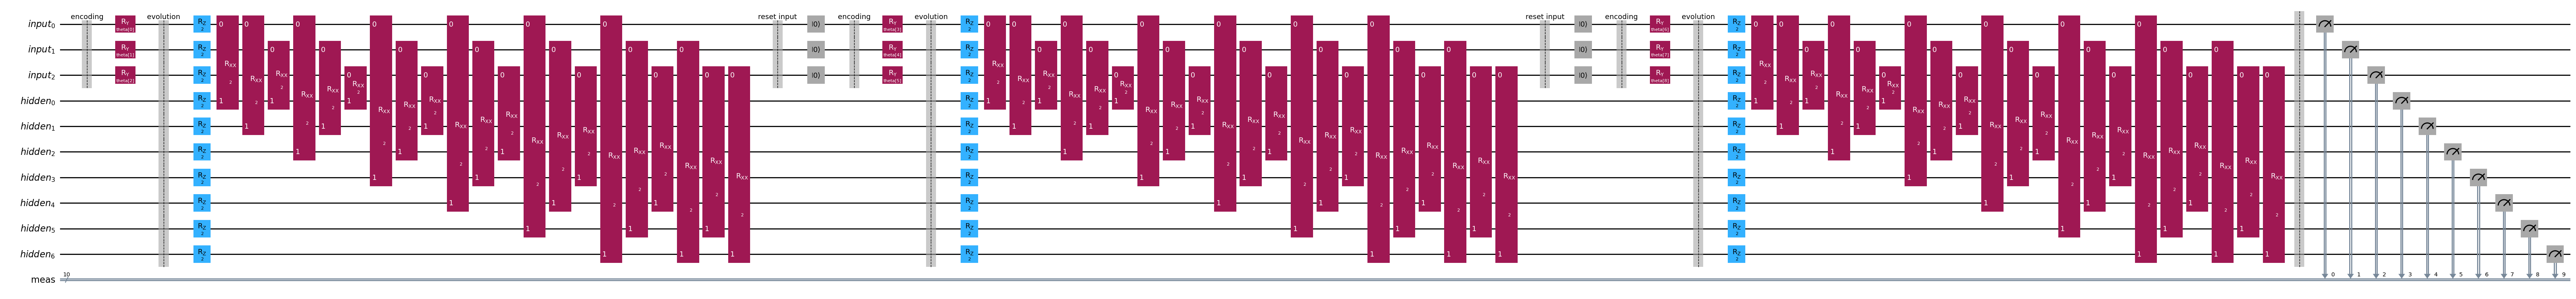

In [7]:
# Build QRC_circuit with the chosen Hamiltonian parameters
from Generate_QRC_circuit import build_QRC_layer, build_QRC_circuit

QRC_circuit = build_QRC_circuit(n_layers, n_input, n_hidden, hamiltonian_params)
QRC_circuit.draw("mpl", fold = 100)

# Step 3: run the QRC transpiled circuit on a backend

In [8]:
###########################
# USER-DEFINED PARAMETERS
###########################

simulator = True   # Choose a real backend or a simulator. Change to False for a real backend

Chosen backend: AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['reset', 'measure', 'x', 'id', 'cz', 'sx']>)
Noise model from backend <IBMBackend('ibm_fez')>


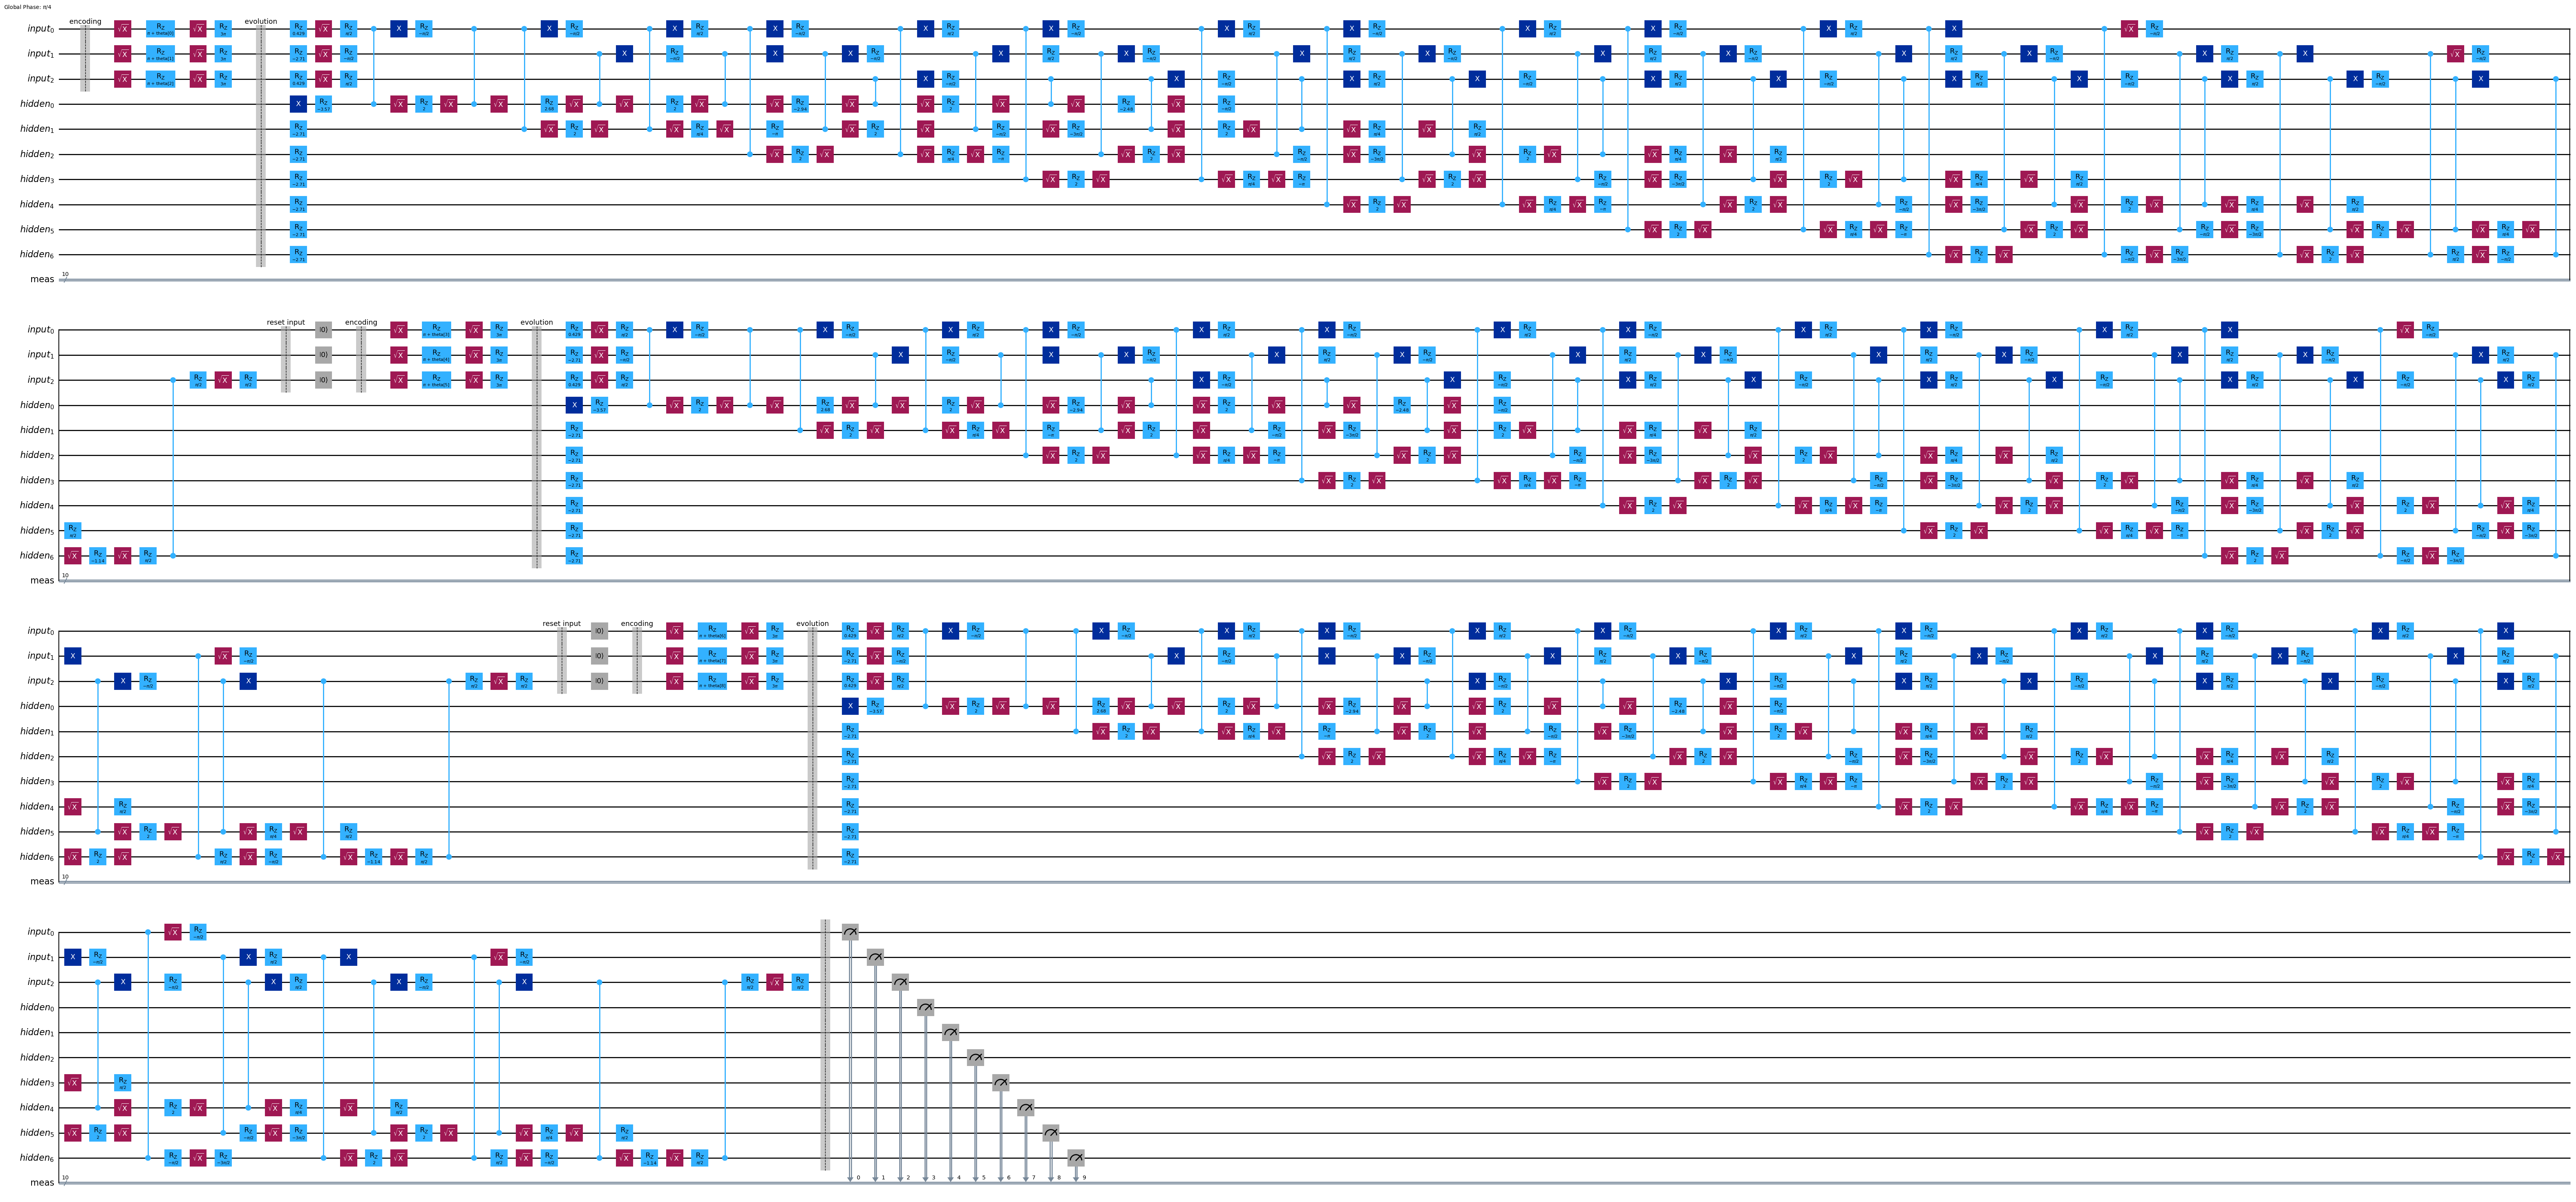

Transpiled circuit depth: 222


In [9]:
from qiskit_aer.noise import NoiseModel

# Choose backend - real or simulator
service = QiskitRuntimeService()

# Choose noise model for simulator backend from a real backend
noise_backend = service.least_busy(operational = True, simulator = False, min_num_qubits = n_hidden + n_input)
noise_model = NoiseModel.from_backend(noise_backend)

if simulator:
    backend = AerSimulator(noise_model = noise_model)    # select a simulator backend
else:
    backend = service.least_busy(simulator = False, operational = True)   # select a real backend
    # Set simple error suppression/mitigation options
    backend.options.dynamical_decoupling.enable = True
    backend.options.dynamical_decoupling.sequence_type = "XY4"
    backend.options.twirling.enable_gates = True
    backend.options.twirling.num_randomizations = "auto"
        
print(f"Chosen backend: {backend}")
print(f"Noise model from backend {noise_backend}")

# Transforms the circuit to match the backend device's Instruction Set Architecture (ISA)
pm = generate_preset_pass_manager(backend = backend, optimization_level = 3)   # simulator backend chosen due to runtime limitation on real hardware
isa_QRC_circuit = pm.run(QRC_circuit)
display(isa_QRC_circuit.draw(output = "mpl", fold = 100))
print(f"Transpiled circuit depth: {isa_QRC_circuit.depth()}")

In [10]:
shots = 10000
print(f"Chosen shots per run: {shots}")

# Create list of PUBs to pass to be run with the Sampler primitive
pubs = [(isa_QRC_circuit, param_set) for param_set in X]

# Run the circuit on the chosen backend. We generate a single job containing all parametrization runs (PUBs) of the circuit 
sampler = Sampler(mode = backend)
job = sampler.run(pubs, shots = shots)

# Gets results
results = job.result()
print("Results generated")

Chosen shots per run: 10000
Results generated


# Step 4.1: post processing of data - training

In [11]:
# Generate R_train matrix and fill it with expectation values computed from results
R_train = np.zeros((train_size, n_qubits))

for day in range(train_size):
    day_outcomes = results[day].data.meas.get_counts()
    
    # Convert outcomes to expectation values
    exp_values = np.zeros((n_qubits))
    for bitstring, count in day_outcomes.items():
        reversed_bitstring = bitstring[::-1]
        prob = count / shots
        
        for bit in range(n_qubits):
            exp_values[bit] = exp_values[bit] + prob * (1 if reversed_bitstring[bit] == '0' else -1)
    
    # Feed expectation values to R_train
    R_train[day] = exp_values

print(f"R_train shape: {R_train.shape}\n")

R_train shape: (347, 10)



In [12]:
# Perform training: ridge regression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

readout = Ridge(alpha = 1e-8)  # use Ridge method. Value alpha chosen as in the reference paper
readout.fit(R_train, y_train)
print("Readout training completed")

# Check training "quality"
y_train_pred = readout.predict(R_train)
qrc_mse_train = mean_squared_error(y_train, y_train_pred, multioutput = 'raw_values')  # One MSE per each PC
print(f"PC1 Train MSE: {qrc_mse_train[0]:.6f}")
print(f"PC2 Train MSE: {qrc_mse_train[1]:.6f}")
print(f"PC3 Train MSE: {qrc_mse_train[2]:.6f}")

Readout training completed
PC1 Train MSE: 1.044899
PC2 Train MSE: 1.834484
PC3 Train MSE: 0.949569


# Step 4.2: post processing of data - test

In [13]:
# Generate R_test matrix and fill it with expectation values computed from results
R_test = np.zeros((test_size, n_qubits))

for day in range(test_size):
    day_outcomes = results[train_size + day].data.meas.get_counts()
    
    # Convert outcomes to expectation values
    exp_values = np.zeros(n_qubits)
    for bitstring, count in day_outcomes.items():
        reversed_bitstring = bitstring[::-1]
        prob = count / shots
        for bit in range(n_qubits):
            exp_values[bit] += prob * (1 if reversed_bitstring[bit] == '0' else -1)
    
    # Feed expectation values to R_train
    R_test[day] = exp_values

print(f"R_test shape: {R_test.shape}\n")

R_test shape: (150, 10)



In [14]:
# Test predictions
y_test_pred = readout.predict(R_test)
qrc_mse_test = mean_squared_error(y_test, y_test_pred, multioutput = 'raw_values')  # One MSE per each PC
print(f"PC1 Test MSE: {qrc_mse_test[0]:.6f}")
print(f"PC2 Test MSE: {qrc_mse_test[1]:.6f}")
print(f"PC3 Test MSE: {qrc_mse_test[2]:.6f}")

PC1 Test MSE: 0.829983
PC2 Test MSE: 1.327312
PC3 Test MSE: 3.183265


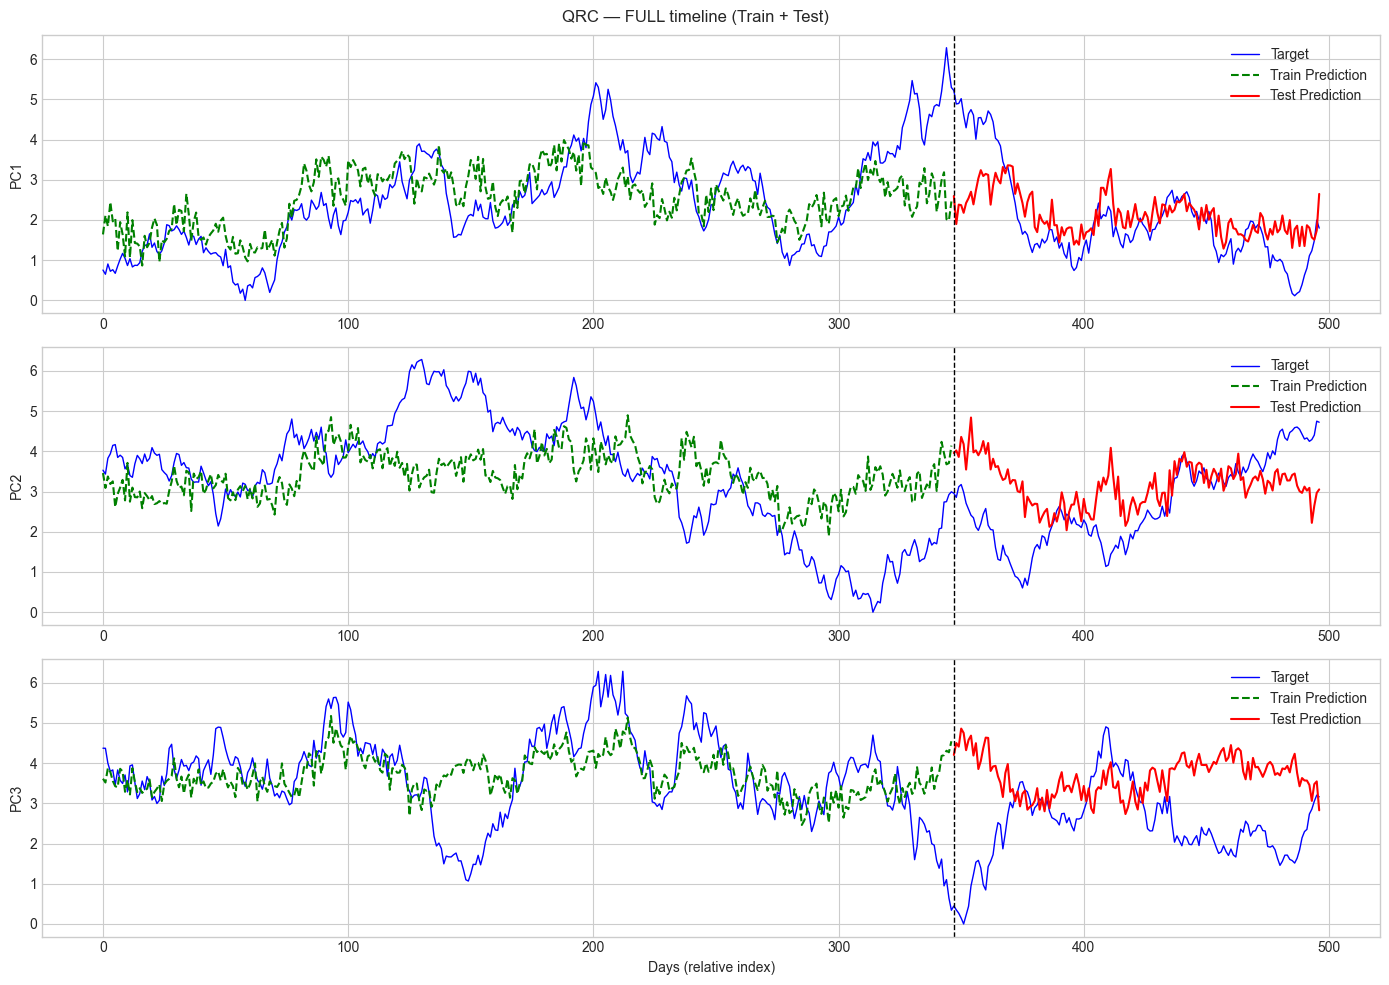

In [15]:
# Plot results
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

pcs = ["PC1", "PC2", "PC3"]

y_pred_full = np.vstack([y_train_pred, y_test_pred])
timesteps = np.arange(len(y_pred_full))

for i in range(3):
    axes[i].plot(timesteps, np.hstack([y_train[:, i], y_test[:, i]]),
                 'b-', label='Target', linewidth=1)
    
    axes[i].plot(timesteps[:train_size], y_pred_full[:train_size, i],
                 'g--', linewidth=1.5, label='Train Prediction')
    
    axes[i].plot(timesteps[train_size:], y_pred_full[train_size:, i],
                 'r-', linewidth=1.5, label='Test Prediction')
    
    axes[i].axvline(x = train_size, color = 'black', linestyle = '--', linewidth = 1)  # Vertical line when prediction starts
    axes[i].set_ylabel(pcs[i])
    axes[i].legend()

axes[-1].set_xlabel("Days (relative index)")
fig.suptitle("QRC — FULL timeline (Train + Test)")
plt.tight_layout()
plt.savefig("QRC_full_dataset.png", dpi=300, bbox_inches='tight')
plt.show()

# Step 5.1: forecast - generate future predictions over two weeks

In [16]:
# Predicts future prices for the next two weeks
future_days = 14
last_available_pcs = y[-lags:].tolist()    # PCs of the last "lags" days
future_pred = []

# Run QRC iteratively (same sampler/backend/isa_QRC_circuit as in training). This could be done in a Session, if available
for day in range(future_days):
    last_params = np.hstack(last_available_pcs[-3:])
    
    pub = (isa_QRC_circuit, last_params)
    prediction_job = sampler.run([pub], shots = shots)
    result = prediction_job.result()[0]
    counts = result.data.meas.get_counts()
    
    # Convert outcomes to expectation values
    exp_values = np.zeros(n_qubits)
    for bitstring, count in counts.items():
        reversed_bitstring = bitstring[::-1]
        prob = count / shots
        for bit in range(n_qubits):
            exp_values[bit] += prob * (1 if reversed_bitstring[bit] == '0' else -1)
    
    # Predict PCs for the next day
    next_pc = readout.predict(exp_values.reshape(1, -1))[0]
    future_pred.append(next_pc)   # store prediction for further analysis
    last_available_pcs.append(next_pc)     # append to last_available_pcs so it becomes part of future lags, re-used in the loop
    
future_pred = np.array(future_pred)
print("Future forecast shape:", future_pred.shape)  # (14, 3)

Future forecast shape: (14, 3)


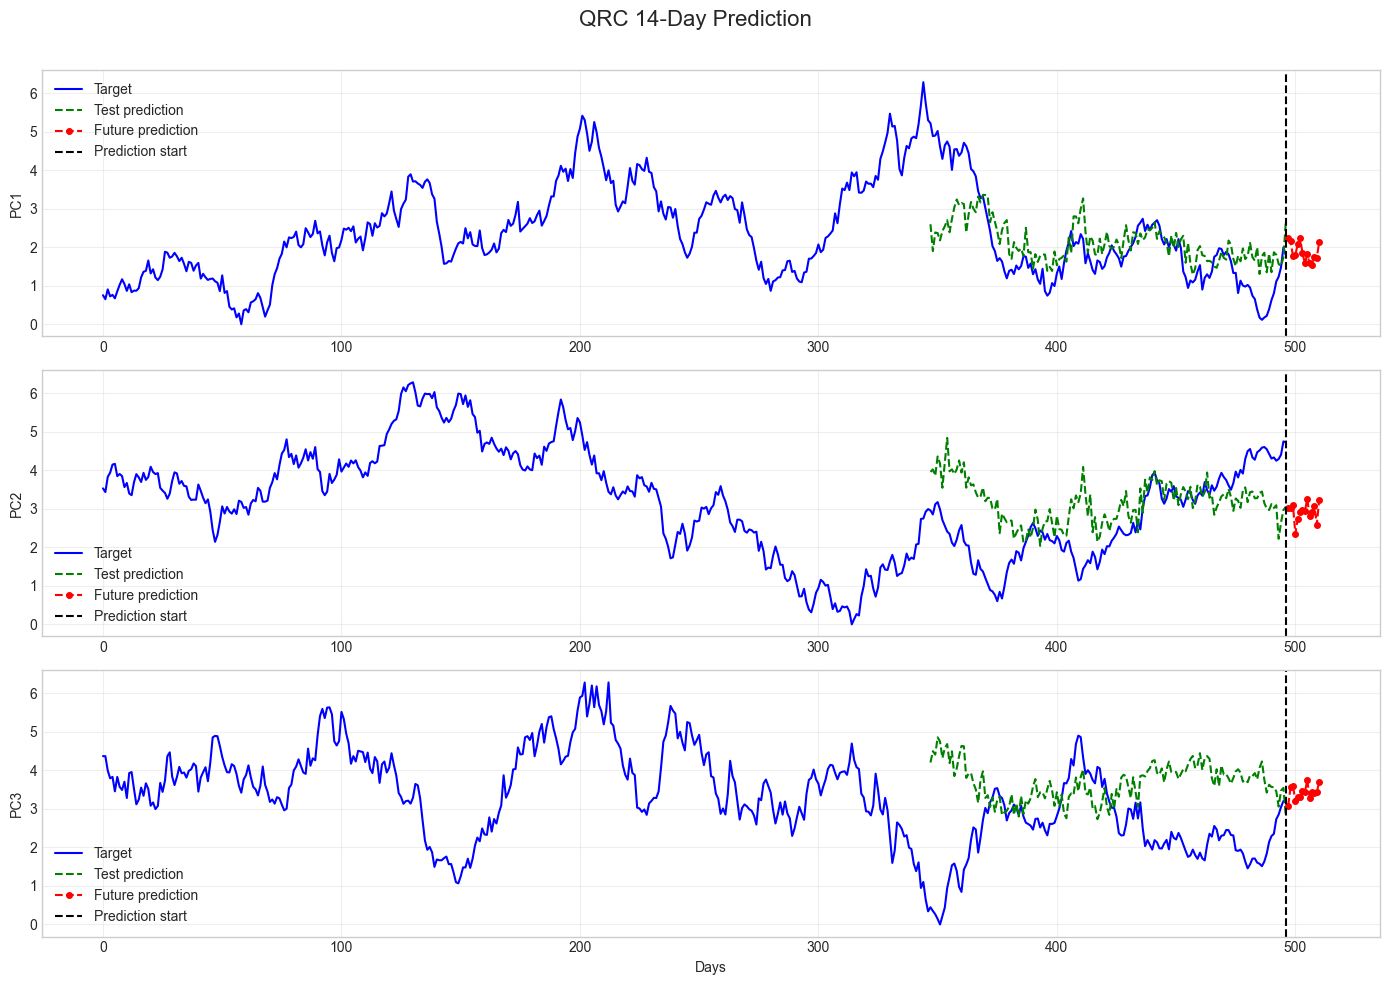

In [17]:
# Plot results
components = ['PC1', 'PC2', 'PC3']

plt.figure(figsize=(14, 10))
plt.suptitle("QRC 14-Day Prediction", fontsize=16)

for i in range(3):
    ax = plt.subplot(3, 1, i+1)

    # Provided values (full dataset)
    ax.plot(y[:, i],
            color = "blue", label = "Target")

    # QRC prediction on test set
    ax.plot(
        range(len(y_train), len(y_train) + len(y_test)),
        y_test_pred[:, i],
        'g--',
        label = "Test prediction")

    # QRC prediction for future 14 days
    future_x = np.arange(len(y), len(y) + future_days)
    ax.plot(
        future_x,
        future_pred[:, i],
        'ro--',
        markersize=4,
        label="Future prediction")

    # Mark prediction boundary
    ax.axvline(len(y) - 1, color="black", linestyle="--", label="Prediction start")
    
    ax.set_ylabel(components[i])
    ax.grid(alpha=0.3)
    ax.legend(loc="upper left")
    # Legend positioning
    if i == 0:
        ax.legend(loc="upper left")
    else:
        ax.legend(loc="lower left")

plt.xlabel("Days")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig("QRC_with_predictions.png", dpi=300, bbox_inches='tight')
plt.show()

# Step 5.2: forecast - revert PCs to swapoptions and save in .csv file

In [18]:
# Revert normalization of PCs
future_pred_unnorm = pca_min_values + (pca_max_values - pca_min_values) * (future_pred / (2 * np.pi))
future_prices = pca.inverse_transform(future_pred_unnorm)
print("Future prices shape:", future_prices.shape)

Future prices shape: (14, 224)


In [19]:
# Reconstruct dataset format and save
last_date = pd.to_datetime(dates_dataset.iloc[-1])
future_dates = pd.date_range(start = last_date + pd.Timedelta(days=1), periods = future_days, freq = "D")
price_cols = prices_dataset.columns.tolist()
future_df = pd.DataFrame(future_prices, columns = price_cols)
future_df["Date"] = future_dates.values

print("Output shape:", future_df.shape)

output_file = "QRC_future_prices_14days.csv"
future_df.to_csv(output_file, index = False, sep=';')   # Italian Excel requires ; separator
print("Saved:", output_file)

Output shape: (14, 225)
Saved: QRC_future_prices_14days.csv


# Step 6: evaluate precision and compare with Gradient Boosting

In [32]:
# Compare precision with the classical Gradient Boosting method, evaluated on the test set
from sklearn.ensemble import GradientBoostingRegressor

# Define training and test features for Gradient Boosting. GB targets are already defined: y_train and y_test
pc_train_gb = X[:train_size]
pc_test_gb = X[train_size:]

# Train Gradient Boosting model
gb_models = []
gb_mse_test = []

for i in range(3):  # PC1, PC2, PC3
    # Fit training
    gb = GradientBoostingRegressor(n_estimators = 100, learning_rate = 0.1)
    gb.fit(pc_train_gb, y_train[:, i])
    
    # Predict test
    gb_preds = gb.predict(pc_test_gb)
    gb_mse_pc = mean_squared_error(y_test[:, i], gb_preds)
    
    gb_models.append(gb)
    gb_mse_test.append(gb_mse_pc)
    
# Print comparison
print(f"Parameters for QRC: hidden qubits = {n_hidden}, \u03BD = {nu}, t = {dt}")
for i, comp in enumerate(['PC1','PC2','PC3']):
    print(f"{comp}: QRC={qrc_mse_test[i]:.6f}  |  GB_BASELINE={gb_mse_test[i]:.6f}")

Parameters for QRC: hidden qubits = 7, ν = 1.0, t = 1.0
PC1: QRC=0.829983  |  GB_BASELINE=0.106158
PC2: QRC=1.327312  |  GB_BASELINE=0.065834
PC3: QRC=3.183265  |  GB_BASELINE=0.104617
